In [102]:
using CairoMakie
using TimerOutputs

include("../src/Mesh.jl")
include("../src/Sources.jl")
include("../src/Matrix.jl")
include("../src/Visualization.jl")

plot_mesh (generic function with 1 method)

In [103]:
ε = 8.854e-12
μ = 4e-7 * π
c = 1 / √(μ * ε)

2.9979563769321626e8

In [104]:
# Generate mesh
Nel = 25
l = [1038, 955, 956, 932, 916, 906, 897, 891, 887] * 1e-3
x = [0, 312, 447, 699, 1050, 1482, 1986, 2553, 3168] * 1e-3
a = 6.35e-3 / 2

nodes = [0 0 0]
edges = [[]]

for (len, pos) ∈ zip(l, x)
    n, e = mesh_segment([pos -len/2 0], [pos len/2 0], Nel, size(nodes, 1))
    nodes = vcat(nodes, n)
    edges = vcat(edges, e)
end

nodes = nodes[2:end, :]
edges = edges[2:end]

end_points = get_end_points(nodes, edges)
basis_vecs = assign_basis_vector(nodes, edges)

msh = Mesh(nodes, edges, end_points, basis_vecs, a)

Mesh([0.0 -0.519 0.0; 0.0 -0.47748 0.0; … ; 3.168 0.40801999999999994 0.0; 3.168 0.4435 0.0], Vector{Any}[[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]  …  [224, 225], [225, 226], [226, 227], [227, 228], [228, 229], [229, 230], [230, 231], [231, 232], [232, 233], [233, 234]], [1, 26, 27, 52, 53, 78, 79, 104, 105, 130, 131, 156, 157, 182, 183, 208, 209, 234], [0.0 -1.0 0.0; 0.0 -1.0 0.0; … ; 0.0 -1.0 0.0; 0.0 -1.0 0.0], 0.003175)

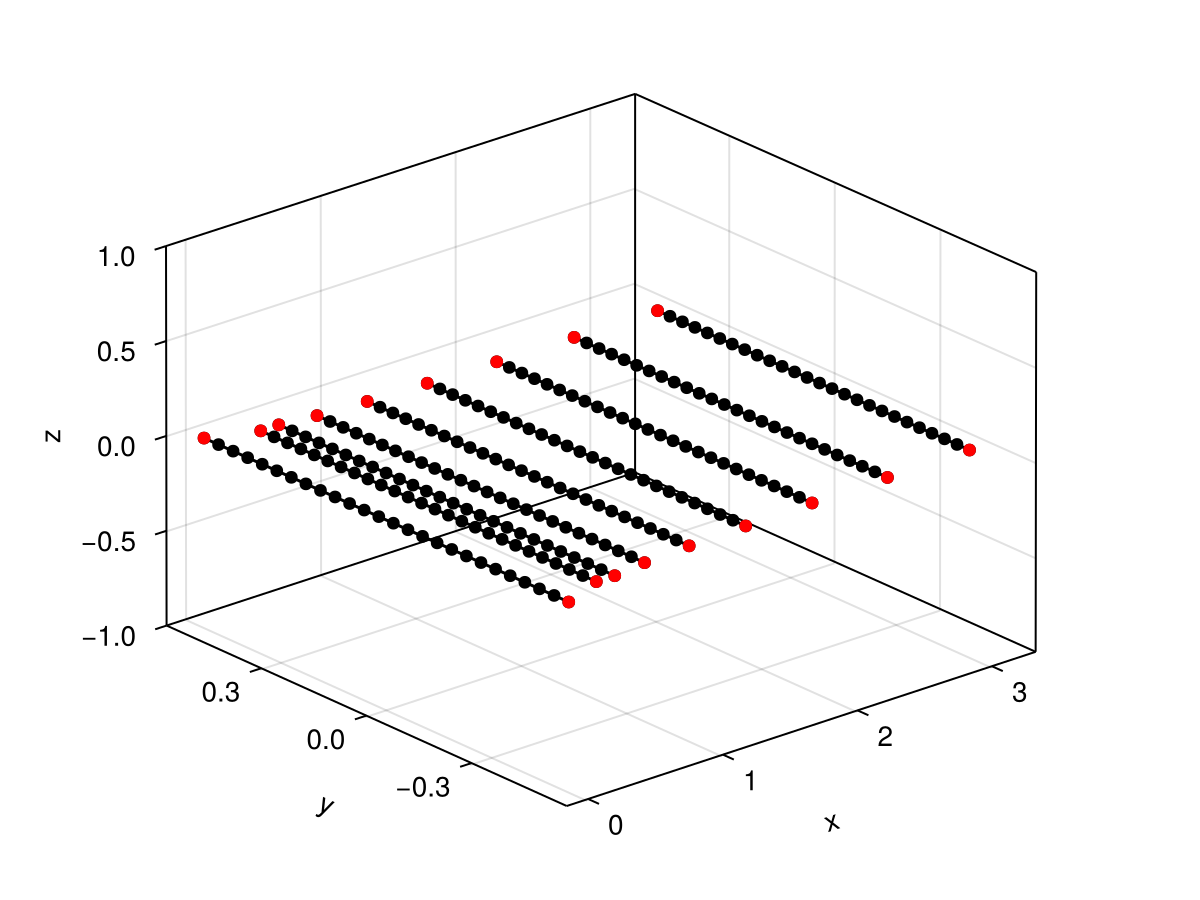

In [105]:
# Plot the antenna in 3D
f_msh = plot_mesh(msh)
f_msh

In [106]:
# Mid-point feed
Vin = 1
idx_mid = Integer(Nel + ceil(Nel / 2))
src1 = VoltageSource(Vin, idx_mid)

src = [src1]

1-element Vector{VoltageSource}:
 VoltageSource(1, 38)

In [107]:
reset_timer!()

# Assemble system equations
@timeit "assemble" Z, V = assemble_global(msh, src, 146e6, μ, ε)

# Solve system
@timeit "solve" Isol = Z \ V

print_timer()

e = msh.edges[src[1].edge]
Iin = sum(Isol[e]) / length(Isol[e])
Zin = Vin / Iin

─────────────────────────────────────────────────────────────────────────
                                Time                    Allocations      
                       ───────────────────────   ────────────────────────
   Tot / % measured:        4.73s /  99.9%           1.58GiB / 100.0%    

Section        ncalls     time    %tot     avg     alloc    %tot      avg
─────────────────────────────────────────────────────────────────────────
assemble            1    4.73s  100.0%   4.73s   1.58GiB   99.9%  1.58GiB
  outer loop        1    4.34s   91.8%   4.34s   1.57GiB   99.3%  1.57GiB
    element     50.6k    3.78s   80.0%  74.8μs   1.47GiB   93.2%  30.5KiB
solve               1   2.24ms    0.0%  2.24ms    862KiB    0.1%   862KiB
─────────────────────────────────────────────────────────────────────────


23.67637778292646 - 20.540730439345253im

In [108]:
# Input impedance frequency sweep
frequencies = range(144e6, 148e6, 20)
Zin = zeros(Complex{Float64}, length(frequencies))

reset_timer!()

@timeit "frequency sweep" for (i, f) ∈ enumerate(frequencies)
    # Assemble system equations
    @timeit "assembly" Z, V = assemble_global(msh, src, f, μ, ε)

    # Solve system
    @timeit "solve" Isol = Z \ V

    e = msh.edges[src[1].edge]
    Iin = sum(Isol[e]) / length(Isol[e])
    Zin[i] = Vin / Iin
end

print_timer()

────────────────────────────────────────────────────────────────────────────
                                   Time                    Allocations      
                          ───────────────────────   ────────────────────────
    Tot / % measured:          44.1s /  99.6%           31.4GiB / 100.0%    

Section           ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────
frequency sweep        1    44.0s  100.0%   44.0s   31.4GiB  100.0%  31.4GiB
  assembly            20    43.9s   99.9%   2.20s   31.4GiB   99.9%  1.57GiB
    outer loop        20    43.9s   99.9%   2.20s   31.4GiB   99.9%  1.57GiB
      element      1.01M    37.6s   85.4%  37.1μs   29.5GiB   93.7%  30.5KiB
  solve               20   44.8ms    0.1%  2.24ms   16.8MiB    0.1%   861KiB
────────────────────────────────────────────────────────────────────────────


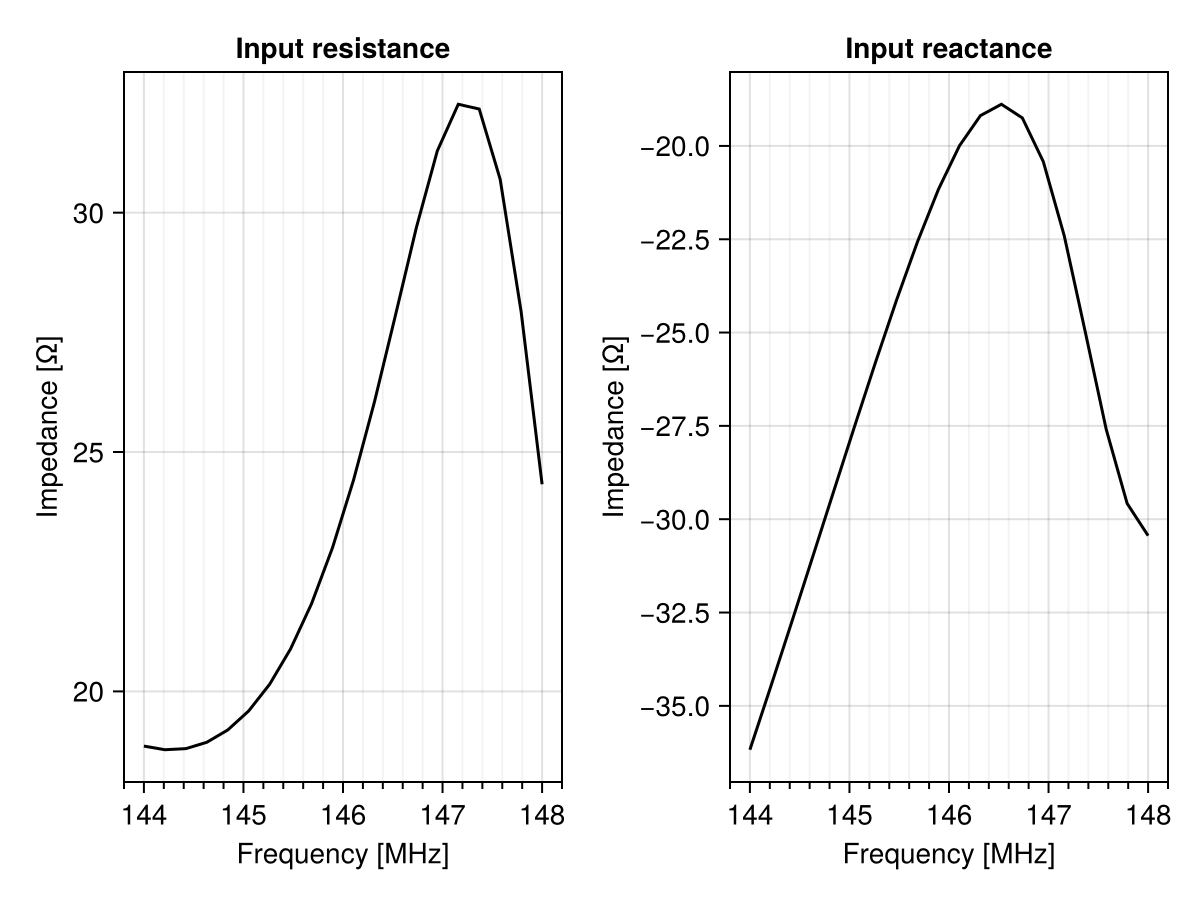

In [109]:
f = Figure()
ax1 = Axis(
    f[1, 1],
    xlabel="Frequency [MHz]", ylabel="Impedance [Ω]", title="Input resistance",
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5)
)

lines!(ax1, frequencies * 1e-6, real.(Zin), color=:black)

ax2 = Axis(
    f[1, 2],
    xlabel="Frequency [MHz]", ylabel="Impedance [Ω]", title="Input reactance",
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5)
)

lines!(ax2, frequencies * 1e-6, imag.(Zin), color=:black)

f